# **Diabetes prediction with explainable AI (BINARY CLASSIFICATION)**

In [1]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv.xlsx to diabetes.csv.xlsx


In [2]:
import pandas as pd
df = pd.read_excel("diabetes.csv.xlsx")
display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# Cell 1 — imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import shap
import joblib  # for saving scaler

# For nicer plots
sns.set(style="whitegrid")


In [5]:
# Cell 3 — quick EDA
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std    

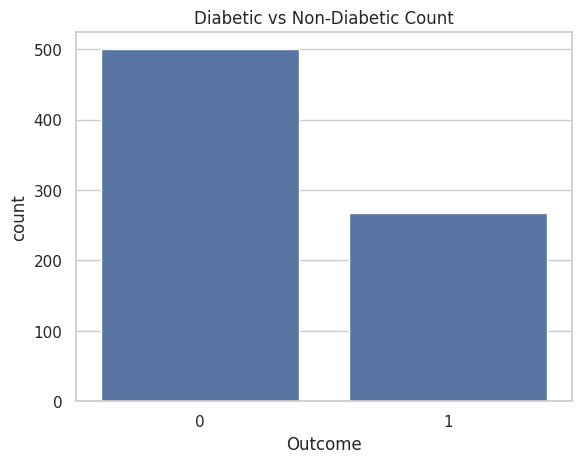

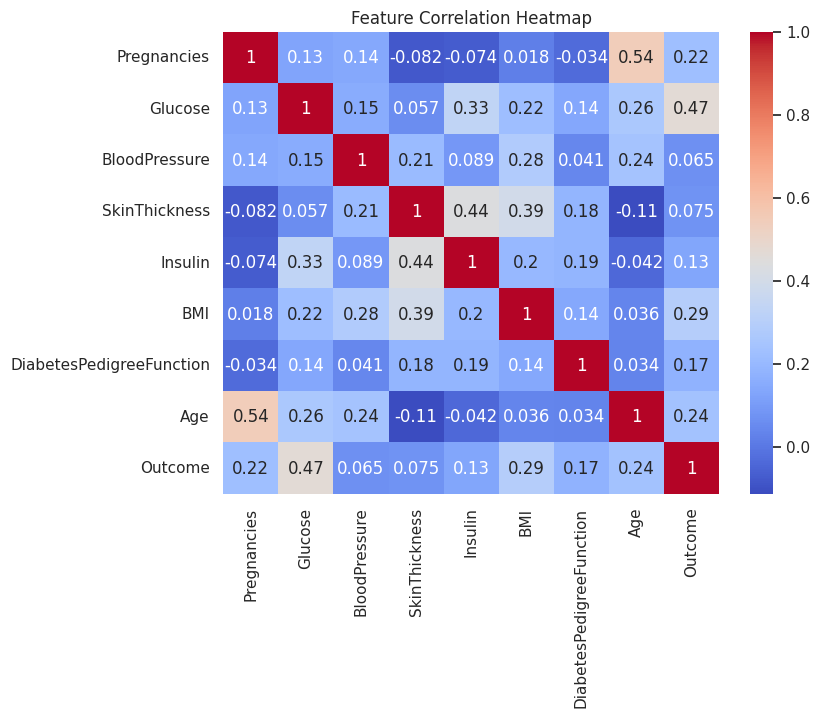

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class distribution
sns.countplot(x='Outcome', data=df)
plt.title('Diabetic vs Non-Diabetic Count')
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [7]:
# Cell 4 — Replace zeros with NaN for physiologically-impossible zeros
cols_with_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

# Show missing count
print(df.isna().sum())

# Impute missing values with median (robust)
df.fillna(df.median(), inplace=True)
print("Missing after impute:", df.isna().sum().sum())


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Missing after impute: 0


In [8]:
# Cell 5 — Feature/Label split and scaling
X = df.drop('Outcome', axis=1)
y = df['Outcome']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler for later demo predictions
joblib.dump(scaler, 'scaler.save')

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/Test sizes:", X_train.shape, X_test.shape)

Train/Test sizes: (614, 8) (154, 8)


In [9]:
# Cell 6 — build the ANN
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.15),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833 (3.25 KB)

 Trainable params: 833 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Cell 7 — training with early stopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    callbacks=[es],
    verbose=2
)
# Save model
model.save('diabetes_ann.h5')


Epoch 1/200
39/39 - 2s - 41ms/step - accuracy: 0.6710 - loss: 0.6311 - val_accuracy: 0.7403 - val_loss: 0.5563
Epoch 2/200
39/39 - 0s - 4ms/step - accuracy: 0.7150 - loss: 0.5548 - val_accuracy: 0.7208 - val_loss: 0.5180
Epoch 3/200
39/39 - 0s - 4ms/step - accuracy: 0.7280 - loss: 0.5173 - val_accuracy: 0.7273 - val_loss: 0.4974
Epoch 4/200
39/39 - 0s - 6ms/step - accuracy: 0.7655 - loss: 0.4955 - val_accuracy: 0.7273 - val_loss: 0.4916
Epoch 5/200
39/39 - 0s - 6ms/step - accuracy: 0.7524 - loss: 0.4814 - val_accuracy: 0.7338 - val_loss: 0.4922
Epoch 6/200
39/39 - 0s - 7ms/step - accuracy: 0.7638 - loss: 0.4748 - val_accuracy: 0.7403 - val_loss: 0.4949
Epoch 7/200
39/39 - 0s - 7ms/step - accuracy: 0.7850 - loss: 0.4665 - val_accuracy: 0.7338 - val_loss: 0.4984
Epoch 8/200
39/39 - 0s - 8ms/step - accuracy: 0.7883 - loss: 0.4554 - val_accuracy: 0.7338 - val_loss: 0.5046
Epoch 9/200
39/39 - 0s - 6ms/step - accuracy: 0.7655 - loss: 0.4674 - val_accuracy: 0.7403 - val_loss: 0.5005
Epoch 10/

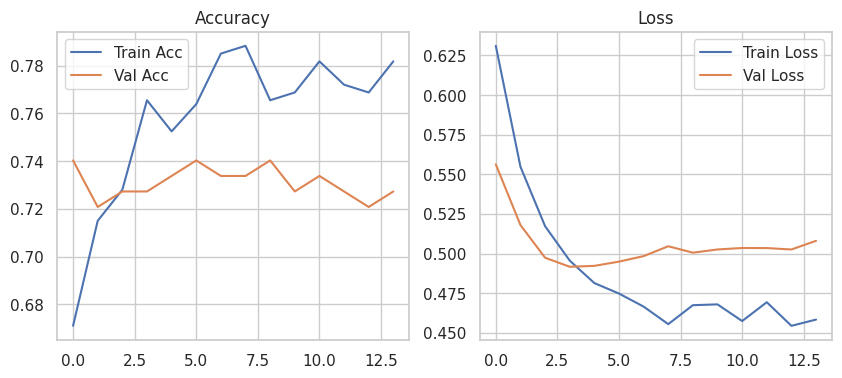

In [11]:
# Cell 8 — plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.7272727272727273

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80       100
           1       0.64      0.52      0.57        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.69       154
weighted avg       0.72      0.73      0.72       154



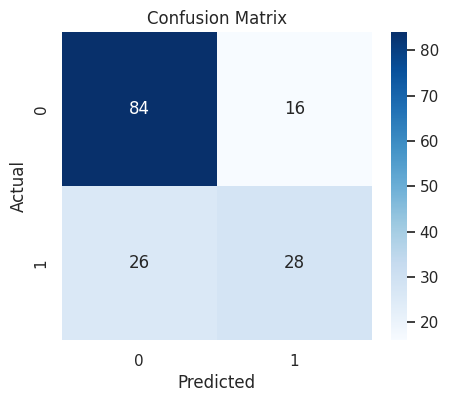

In [12]:
# Cell 9 — evaluation
y_prob = model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()


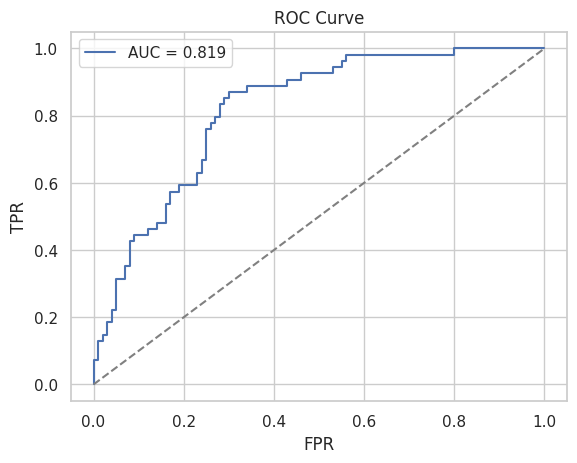

In [13]:
# ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.legend(); plt.title('ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━

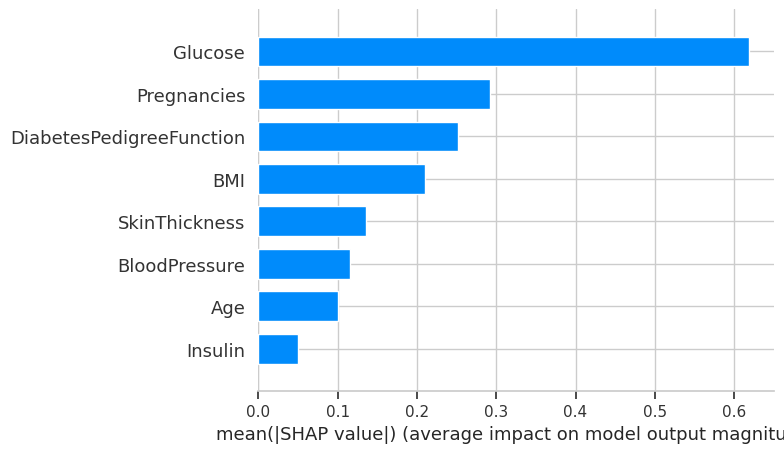

In [14]:
# Cell 10 — SHAP explainability (DeepExplainer / KernelExplainer)
# Note: SHAP can be slow with large models. For small tabular model, use KernelExplainer or TreeExplainer is for tree models.
# For Keras models with tabular data, KernelExplainer works (approx). We'll sample background to speed it up.

# 10.1 prepare a small background sample (use training set)
X_train_sample = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# 10.2 define a wrapper prediction function that returns probability
def predict_proba_for_shap(x):
    return model.predict(x).ravel()

# 10.3 create explainer (KernelExplainer)
explainer = shap.KernelExplainer(predict_proba_for_shap, X_train_sample, link="logit")

# 10.4 compute SHAP values for a small subset of test (to keep runtime small)
X_test_sample = X_test[np.random.choice(X_test.shape[0], 50, replace=False)]
shap_values = explainer.shap_values(X_test_sample, nsamples=100)

# 10.5 global summary plot
feature_names = list(X.columns)
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, plot_type="bar", show=True)


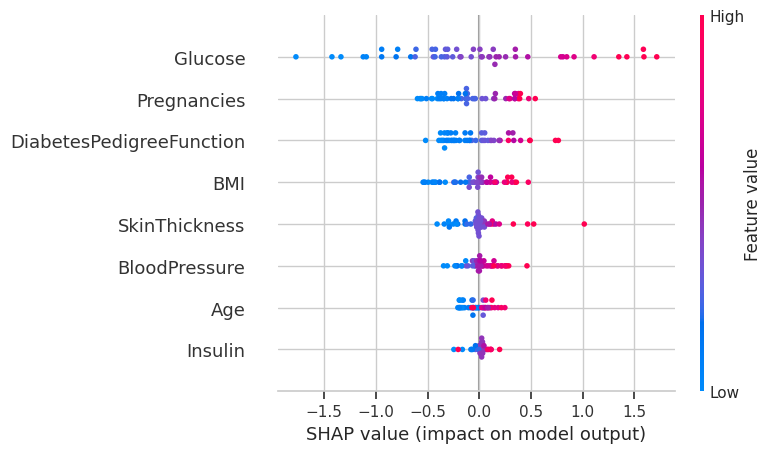

In [15]:
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, show=True)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


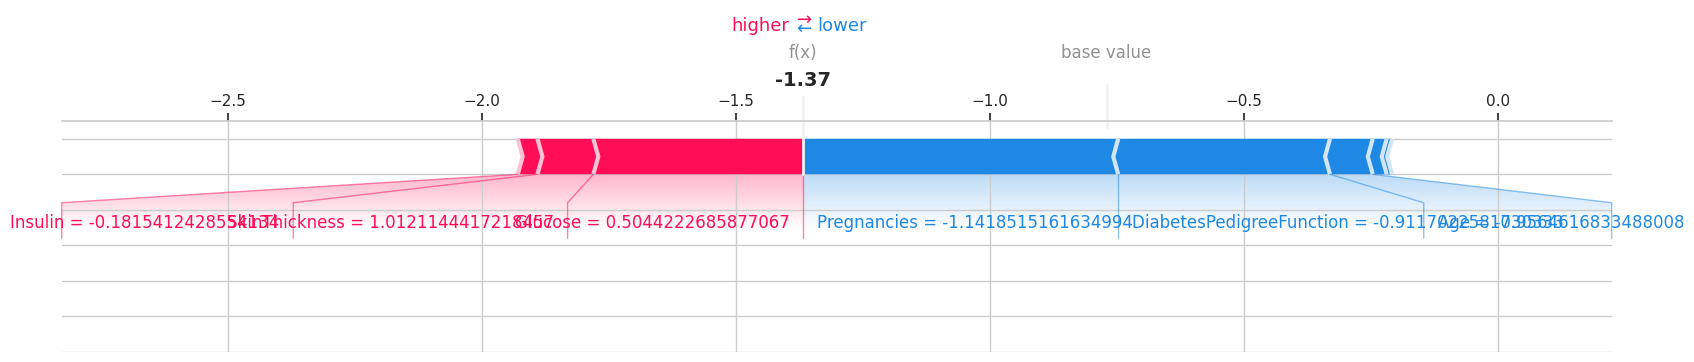

In [16]:
# Cell 11 — per-sample explanation (force plot) for one test sample
# Pick one example from X_test (unscaled original feature order)
idx = 10
sample = X_test[idx].reshape(1, -1)
sample_shap = explainer.shap_values(sample, nsamples=200)

# Force plot (visual interactive).
shap.initjs()
shap.force_plot(explainer.expected_value, sample_shap, sample, feature_names=feature_names, matplotlib=True)


In [18]:
# Cell 12 — mapping back features and demo prediction for a new raw patient sample
# Save scaler and model already done
# Example raw input row (values in the original units)
raw_sample = np.array([[2, 120, 70, 25, 100, 28.0, 0.5, 35]])  # modify values
sc = joblib.load('scaler.save')
raw_scaled = sc.transform(raw_sample)
prob = model.predict(raw_scaled)[0][0]
print("Predicted probability of diabetes:", prob)
print("Predicted class:", "Diabetic" if prob>=0.5 else "Non-Diabetic")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted probability of diabetes: 0.22661957
Predicted class: Non-Diabetic


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
